In [1]:
import os
import json
import glob
import torch
import clip
from tqdm import tqdm
from clip import tokenize
from clip_utils import build_zero_shot_classifier
from imagenet_metadata import IMAGENET_CLASSNAMES, OPENAI_IMAGENET_TEMPLATES

from PIL import Image
import numpy as np
from torchvision.transforms import Resize
import torch.nn.functional as F

from generate_emap import clipmodel, preprocess, imgprocess_keepsize, mm_clipmodel, mm_interpret, \
    clip_encode_dense, grad_eclip, grad_cam, mask_clip, compute_rollout_attention, surgery_model, clip_surgery_map, \
    m2ib_model, m2ib_clip_map

import Game_MM_CLIP.clip as mm_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/infres/pmbathe-24/Projet-IA-Fairness/Grad-Eclip-main/CLIP_Surgery/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


In [2]:

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    # print("pred:", pred.shape) # [5, 10] 
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    acc = [correct[:k,:].float().sum(0).cpu() for k in topk]
    pred_top1 = pred[0,:]
    return acc, pred_top1

def make_grids(h, w):
    shifts_x = torch.arange(
        0, w, 1)
    shifts_y = torch.arange(
        0, h, 1)
    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing='ij')
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    grids = torch.stack((shift_x, shift_y), dim=1)
    return grids

def random_pixel(image, poses):
    # adjust the size of perturbation each step based on the size of object size 
    h,w, _ = image.shape 
    random_patch = torch.rand(len(poses), 3) * 255.
    xs, ys = zip(*poses)
    image[ys, xs, :] = random_patch
    return image

def delection_process(image, heatmap, L, cal_gap, del_path, img_name):
    image_array = np.array(image).copy()
    image_array.setflags(write=1)
    h, w = heatmap.shape
    grids = make_grids(h, w)
    order = np.argsort(-heatmap.reshape(-1))
    area = h*w
    pixel_once = max(1, int(area/(2*L)))

    del_imgs = []
    for step in range(1,L+1):
        image_array = random_pixel(image_array, grids[order[(step-1)*pixel_once:step*pixel_once]])
        if step%cal_gap == 0:
            pil_image = Image.fromarray(np.uint8(image_array))
            img_clipreprocess = preprocess(pil_image).to(device).unsqueeze(0)
            del_imgs.append(img_clipreprocess)
            # pil_image.save(del_path+'/{}_{}.jpg'.format(img_name, step))
    return torch.cat(del_imgs, dim=0)


In [3]:
def generate_hm(hm_type, img, gt, pred, resize):
    img_keepsized = imgprocess_keepsize(img).to(device).unsqueeze(0)
    outputs, v_final, last_input, v, q_out, k_out,\
        attn, att_output, map_size = clip_encode_dense(img_keepsized)
    img_embedding = F.normalize(outputs[:,0], dim=-1)
    if "gt" in hm_type:
        exp_target = gt
        txt_embedding = zero_shot_weights[:, gt]
        cosine = (img_embedding @ txt_embedding)[0]
    elif "pred" in hm_type:
        exp_target = pred
        txt_embedding = zero_shot_weights[:, pred]
        cosine = (img_embedding @ txt_embedding)[0]
    else:
        None

    if hm_type == "selfattn":
        emap = attn[0,:1,1:].detach().reshape(*map_size)
    elif "gradcam" in hm_type:
        emap = grad_cam(cosine, last_input, map_size)
    elif "maskclip" in hm_type:
        emap = mask_clip(txt_embedding.unsqueeze(-1), v_final, k_out, map_size)[0]
    elif "eclip" in hm_type:
        emap = grad_eclip(cosine, q_out, k_out, v, att_output, map_size, withksim=False) \
            if "wo-ksim" in hm_type else grad_eclip(cosine, q_out, k_out, v, att_output, map_size, withksim=True)
    elif "game" in hm_type:
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(IMAGENET_CLASSNAMES[exp_target]).to(device)
        emap = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device)[0]
    elif "rollout" in hm_type:
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(IMAGENET_CLASSNAMES[exp_target]).to(device)   
        attentions = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device, rollout=True)      
        emap = compute_rollout_attention(attentions)[0]
    elif "surgery" in hm_type:
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
        all_texts.insert(0, IMAGENET_CLASSNAMES[exp_target])
        emap = clip_surgery_map(model=surgery_model, image=img_clipreprocess, texts=all_texts, device=device)[0,:,:,0]
    elif "m2ib" in hm_type:
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        emap = m2ib_clip_map(model=m2ib_model, image=img_clipreprocess, texts=IMAGENET_CLASSNAMES[exp_target], device=device)
        emap = torch.tensor(emap)


    emap -= emap.min()
    emap /= emap.max()
    emap = resize(emap.unsqueeze(0))[0].cpu().numpy()
    return emap

In [ ]:


if __name__ == '__main__':
    data_path = "./data/imagenet/val/"
    del_path = './data/imagenet/del_samples/' ### for debug, saving deleting samples

    # hm_types = ['eclip-wo-ksim_gt', 'eclip-wo-ksim_pred', 'eclip_gt', 'eclip_pred', 'game_gt', 'game_pred',
    #         'gradcam_gt', 'gradcam_pred', 'maskclip_gt', 'maskclip_pred', 'selfattn', 'surgery_gt', 'surgery_pred', 'm2ib_gt', 'm2ib_pred']

    hm_type = 'eclip_gt'
    print("hm type:", hm_type)

    zero_shot_weights = build_zero_shot_classifier(
        clipmodel,
        classnames=IMAGENET_CLASSNAMES,
        templates=OPENAI_IMAGENET_TEMPLATES,
        num_classes_per_batch=10,
        device=device,
        use_tqdm=True
        )
    print("[class name embeddings]:", zero_shot_weights.shape)  # [512, 1000]


    top1 = torch.zeros([11])
    top5 = torch.zeros([11])
    top10 = torch.zeros([11])
    n = torch.zeros([11])

    L = 100
    cal_gap = 10
    with open("imagenet_class_index.json", "r") as ff:
        class_dict = json.load(ff)
        for label, values in list(class_dict.items()):
            label = int(label)
            folder = values[0]
            print("Start: Processing the {}th folder, target class name: {}".format(label, IMAGENET_CLASSNAMES[label]))

            # if not os.path.exists(del_path+folder):
            #     os.makedirs(del_path+folder)
            files = os.listdir(data_path+folder)

            for f in files:
                img_name = f.split(".")[0]
                img = Image.open(os.path.join(data_path, folder, f )).convert("RGB")
                w, h = img.size
                # in case there is too large image
                if min(w,h) > 640:
                    scale = min(w,h) / 640
                    hs = int(h/scale)
                    ws = int(w/scale)
                    # print(img_name, w, h, ws, hs)
                    img = img.resize((ws,hs))
                w, h = img.size
                resize = Resize((h,w))
                # make prediction
                with torch.no_grad():
                    img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
                    img_clip_embedding = clipmodel.encode_image(img_clipreprocess)
                    logits = 100. * img_clip_embedding @ zero_shot_weights
                    target = torch.tensor([label]).to(device)
                    [acc1, acc5, acc10], pred_top1 = accuracy(logits, target, topk=(1, 5, 10))
                    top1[:1] += acc1
                    top5[:1] += acc5
                    top10[:1] += acc10
                    n[0] += 1

                hm = generate_hm(hm_type, img.copy(), label, pred_top1.item(), resize)
                del_imgs = delection_process(img, hm, L, cal_gap, del_path+folder, '{}_{}'.format(img_name, hm_type)) # 10 deletion steps
                # 10, 3, 224, 224
                img_clip_embedding = clipmodel.encode_image(del_imgs)
                logits = 100. * img_clip_embedding @ zero_shot_weights
                target = torch.tensor([label]).repeat(len(img_clip_embedding)).to(device)
                [acc1, acc5, acc10], _ = accuracy(logits, target, topk=(1, 5, 10))
                top1[1:] += acc1
                top5[1:] += acc5
                top10[1:] += acc10
                n[1:] += 1

            print("[clip accuracy] Top1:")
            print("[{}]:".format(hm_type), list((top1 / n).numpy()))

            print("[clip accuracy] Top5:")
            print("[{}]:".format(hm_type), list((top5 / n).numpy()))  

            print("[clip accuracy] Top10:")
            print("[{}]:".format(hm_type), list((top10 / n).numpy()))              


    print("top1 hits:", top1)
    print("top5 hits:", top5)
    print("top10 hits:", top10)
    print("n:", n)
    top1 = top1 / n
    top5 = top5 / n
    top10 = top10 / n

    print("[clip accuracy] Top1:")
    print("[{}]:".format(hm_type), list(top1.numpy()))

    print("[clip accuracy] Top5:")
    print("[{}]:".format(hm_type), list(top5.numpy()))  

    print("[clip accuracy] Top10:")
    print("[{}]:".format(hm_type), list(top10.numpy()))       

100%|██████████| 1000/1000 [00:20<00:00, 48.45it/s]


[class name embeddings]: torch.Size([512, 1000])
Evaluating eclip_gt...
Start: Processing the 0th folder, target class name: tench
[eclip_gt] Final accuracies:
Top1: [0.68 0.58 0.42 0.24 0.12 0.08 0.04 0.02 0.   0.   0.98]
Top5: [0.84 0.76 0.68 0.5  0.32 0.2  0.12 0.08 0.   0.02 1.  ]
Top10: [0.88 0.8  0.74 0.54 0.36 0.24 0.2  0.08 0.02 0.02 1.  ]
Evaluating gradcam_gt...
Start: Processing the 0th folder, target class name: tench
[gradcam_gt] Final accuracies:
Top1: [0.86 0.78 0.64 0.52 0.38 0.34 0.32 0.16 0.14 0.08 0.98]
Top5: [1.   0.94 0.84 0.78 0.7  0.58 0.4  0.4  0.3  0.18 1.  ]
Top10: [1.   0.96 0.86 0.82 0.76 0.66 0.54 0.44 0.36 0.3  1.  ]
Evaluating maskclip_gt...
Start: Processing the 0th folder, target class name: tench
[maskclip_gt] Final accuracies:
Top1: [0.68 0.54 0.32 0.34 0.16 0.12 0.04 0.04 0.04 0.02 0.98]
Top5: [0.88 0.78 0.68 0.48 0.34 0.3  0.2  0.08 0.08 0.06 1.  ]
Top10: [0.98 0.86 0.74 0.56 0.44 0.38 0.28 0.14 0.14 0.08 1.  ]
Evaluating rollout_gt...
Start: Proces

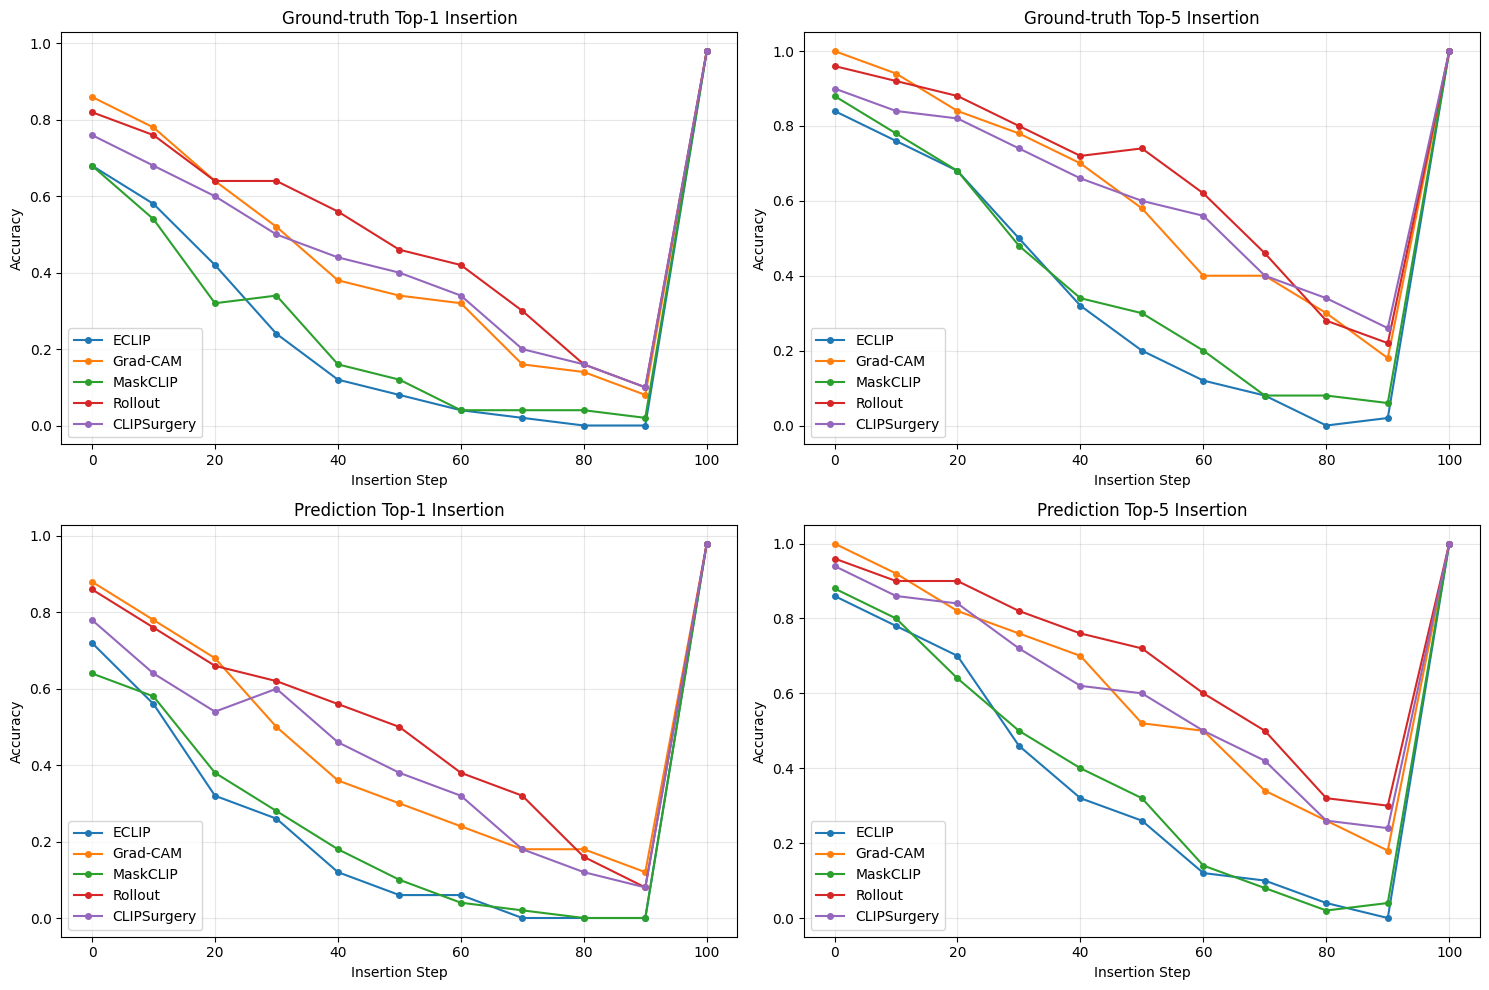


Insertion curves saved to insertion_curves_comparison.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_path = "/home/infres/pmbathe-24/Projet-IA-Fairness/Grad-Eclip-main/data/val/"
ins_path = '/home/infres/pmbathe-24/Projet-IA-Fairness/Grad-Eclip-main/data/ins_samples/'  ### for debug, saving insertion samples

zero_shot_weights = build_zero_shot_classifier(
    clipmodel,
    classnames=IMAGENET_CLASSNAMES,
    templates=OPENAI_IMAGENET_TEMPLATES,
    num_classes_per_batch=10,
    device=device,
    use_tqdm=True
    )
print("[class name embeddings]:", zero_shot_weights.shape)  # [512, 1000]

L = 100
cal_gap = 10

# Define all heatmap types to evaluate
hm_types = ['eclip', 'gradcam', 'maskclip', 'rollout', 'clipsurgery']
extensions = ["gt", "pred"]

# Method name mapping for display
method_names = {
    'gradcam': 'Grad-CAM', 
    'maskclip': 'MaskCLIP',
    'eclip': 'ECLIP',
    'game': 'GAME',
    'rollout': 'Rollout',
    'clipsurgery': 'CLIPSurgery'
}

# Storage for results
all_results = {}
insertion_curves = {}

for ex in extensions: 
    for hm_type_old in hm_types:
        hm_type = f"{hm_type_old}_{ex}"
        print(f"Evaluating {hm_type}...")
        
        # Initialize metrics for each insertion step
        top1 = torch.zeros([11])  # 11 steps: 0, 10, 20, ..., 100
        top5 = torch.zeros([11])
        top10 = torch.zeros([11])
        n = torch.zeros([11])
        
        # Storage for insertion curves
        insertion_steps = list(range(0, L + 1, cal_gap))

        with open("imagenet_class_index.json", "r") as ff:
            class_dict = json.load(ff)
            for label, values in list(class_dict.items())[0:1]:  # process first 100 classes
                label = int(label)
                folder = values[0]
                print("Start: Processing the {}th folder, target class name: {}".format(label, IMAGENET_CLASSNAMES[label]))

                files = os.listdir(data_path+folder)

                for f in files:
                    img_name = f.split(".")[0]
                    img = Image.open(os.path.join(data_path, folder, f)).convert("RGB")
                    w, h = img.size
                    # in case there is too large image
                    if min(w,h) > 640:
                        scale = min(w,h) / 640
                        hs = int(h/scale)
                        ws = int(w/scale)
                        img = img.resize((ws,hs))
                    w, h = img.size
                    resize = Resize((h,w))
                    
                    # make prediction
                    with torch.no_grad():
                        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
                        img_clip_embedding = clipmodel.encode_image(img_clipreprocess)
                        logits = 100. * img_clip_embedding @ zero_shot_weights
                        target = torch.tensor([label]).to(device)
                        [acc1, acc5, acc10], pred_top1 = accuracy(logits, target, topk=(1, 5, 10))
                        top1[-1:] += acc1  # Original image accuracy
                        top5[-1:] += acc5
                        top10[-1:] += acc10
                        n[-1] += 1

                    hm = generate_hm(hm_type, img.copy(), label, pred_top1.item(), resize)
                    ins_imgs = delection_process(img, hm, L, cal_gap, ins_path+folder, '{}_{}'.format(img_name, hm_type))
                    
                    # Evaluate insertion steps
                    img_clip_embedding = clipmodel.encode_image(ins_imgs)
                    logits = 100. * img_clip_embedding @ zero_shot_weights
                    target = torch.tensor([label]).repeat(len(img_clip_embedding)).to(device)
                    [acc1, acc5, acc10], _ = accuracy(logits, target, topk=(1, 5, 10))
                    top1[:-1] += acc1  # Deletion steps accuracy
                    top5[:-1] += acc5
                    top10[:-1] += acc10
                    n[:-1] += 1

        # Calculate final accuracies
        top1_acc = (top1 / n).numpy()
        top5_acc = (top5 / n).numpy()
        top10_acc = (top10 / n).numpy()
        
        print(f"[{hm_type}] Final accuracies:")
        print("Top1:", top1_acc)
        print("Top5:", top5_acc)
        print("Top10:", top10_acc)
        
        # Store results for this method
        if ex == "gt":
            gt_suffix = "_gt"
        else:
            gt_suffix = "_pred" 
            
        base_method = hm_type_old
        
        if base_method not in all_results:
            all_results[base_method] = {}
            
        # Store final accuracy (at step 100)
        all_results[base_method][f'{ex}_top1'] = top1_acc[-1]  # Last step (100%)
        all_results[base_method][f'{ex}_top5'] = top5_acc[-1]
        
        # Store insertion curves
        insertion_curves[hm_type] = {
            'steps': insertion_steps,
            'top1': top1_acc,
            'top5': top5_acc,
            'top10': top10_acc
        }

# Create results table
print("\n" + "="*70)
print("INSERTION EVALUATION RESULTS")
print("="*70)
print(f"{'Method':<15} {'Ground-truth':<20} {'Prediction':<20}")
print(f"{'':15} {'@1':<10} {'@5':<10} {'@1':<10} {'@5':<10}")
print("-"*70)

for method in hm_types:
    if method in all_results:
        method_name = method_names.get(method, method)
        results = all_results[method]
        gt_top1 = results.get('gt_top1', 0)
        gt_top5 = results.get('gt_top5', 0)
        pred_top1 = results.get('pred_top1', 0)
        pred_top5 = results.get('pred_top5', 0)
        
        print(f"{method_name:<15} {gt_top1:<10.4f} {gt_top5:<10.4f} "
              f"{pred_top1:<10.4f} {pred_top5:<10.4f}")

# Save results to CSV
results_data = []
for method in hm_types:
    if method in all_results:
        method_name = method_names.get(method, method)
        results = all_results[method]
        results_data.append({
            'Method': method_name,
            'GT_Top1': results.get('gt_top1', 0),
            'GT_Top5': results.get('gt_top5', 0),
            'Pred_Top1': results.get('pred_top1', 0),
            'Pred_Top5': results.get('pred_top5', 0)
        })

results_df = pd.DataFrame(results_data)
results_df.to_csv('insertion_evaluation_results.csv', index=False)
print(f"\nResults saved to insertion_evaluation_results.csv")

# Plot insertion curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Ground-truth curves
for method in hm_types:
    gt_key = f"{method}_gt"
    pred_key = f"{method}_pred"
    
    if gt_key in insertion_curves:
        curve_data = insertion_curves[gt_key]
        method_name = method_names.get(method, method)
        
        # GT Top-1
        ax1.plot(curve_data['steps'], curve_data['top1'], 
                label=method_name, marker='o', markersize=4)
        
        # GT Top-5
        ax2.plot(curve_data['steps'], curve_data['top5'], 
                label=method_name, marker='o', markersize=4)

# Prediction curves
for method in hm_types:
    pred_key = f"{method}_pred"
    
    if pred_key in insertion_curves:
        curve_data = insertion_curves[pred_key]
        method_name = method_names.get(method, method)
        
        # Pred Top-1
        ax3.plot(curve_data['steps'], curve_data['top1'], 
                label=method_name, marker='o', markersize=4)
        
        # Pred Top-5
        ax4.plot(curve_data['steps'], curve_data['top5'], 
                label=method_name, marker='o', markersize=4)

# Configure subplots
ax1.set_title('Ground-truth Top-1 Deletion')
ax1.set_xlabel('Deletion Step')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Ground-truth Top-5 Deletion')
ax2.set_xlabel('Deletion Step')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.set_title('Prediction Top-1 Deletion')
ax3.set_xlabel('Deletion Step')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.set_title('Prediction Top-5 Deletion')
ax4.set_xlabel('Deletion Step')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('insertion_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nInsertion curves saved to insertion_curves_comparison.png")